In [3]:
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
import networkx as nx


## Clustering of Similar resource activity

In [44]:
resource_activity_df = pd.read_csv("outputs_task_similarity_nb/resource_activity_mean_per_case.csv")

In [45]:
values = resource_activity_df.pop('resource')

In [46]:

K = 5
kmeans = KMeans(n_clusters=K, random_state=2325)
kmeans.fit(resource_activity_df.values )


,n_clusters,5
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,2325
,copy_x,True
,algorithm,'lloyd'


In [47]:
resource_cluster = dict(zip(values, kmeans.labels_))

parsing log, completed traces :: 100%|██████████| 3093/3093 [00:08<00:00, 375.27it/s]


Log imported with 124866 traces.
Nodes: 134, Edges: 1011


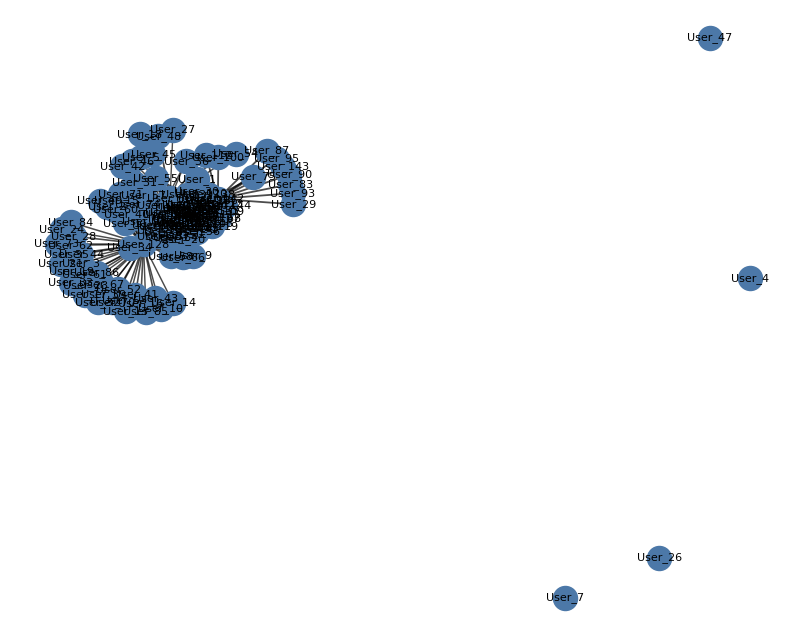

Process Completed


In [48]:
from Assignment_1_1 import main

G = main("BPI2017Denied(3).xes", metric='cosine_distance', threshold_value=.85)

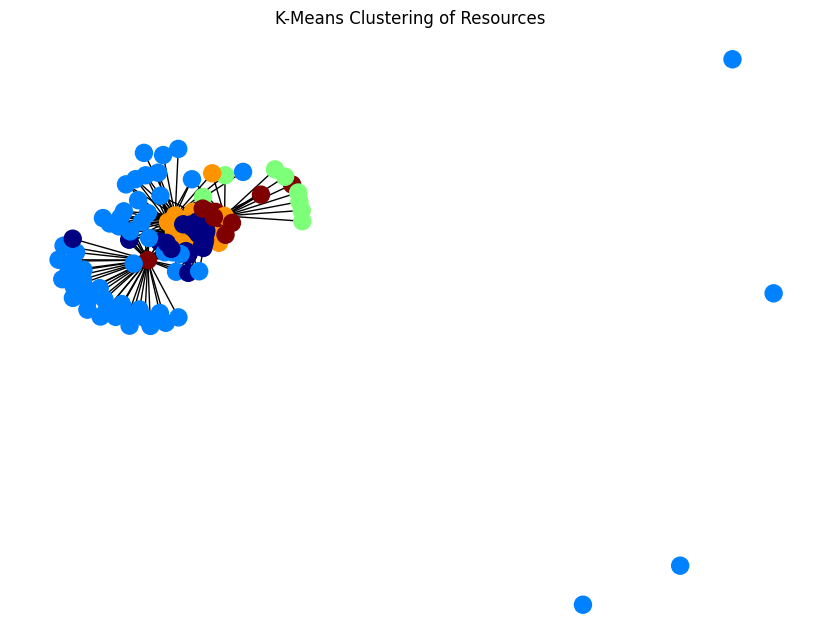

In [49]:
import matplotlib.pyplot as plt

# Get positions for the nodes in the graph
pos = nx.spring_layout(G, seed=42)

# Get the cluster assignments for each node
node_colors = [resource_cluster[(node)] for node in G.nodes()]

# Draw the graph
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=False, node_color=node_colors, cmap=plt.cm.jet, node_size=150, font_size=0, font_color='white')
# edge_labels = nx.get_edge_attributes(G, 'weight')
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title('K-Means Clustering of Resources')
plt.show()

## Hierarchical

In [54]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Perform hierarchical clustering using the 'ward' linkage method
# Linkage computes the distance matrix between clusters
linked = linkage(resource_activity_df.values, method='ward')


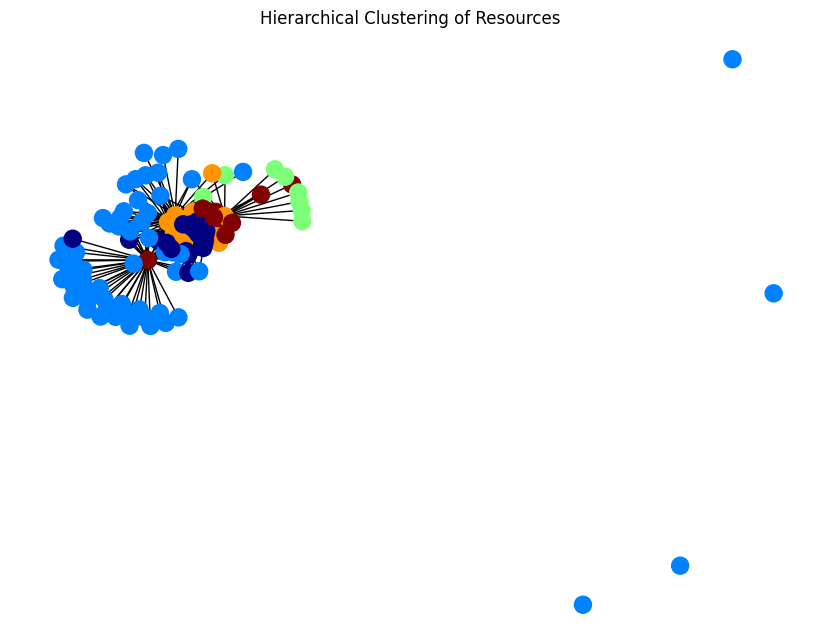

In [56]:
num_clusters = 4
cluster_labels = fcluster(linked, num_clusters, criterion='maxclust')

resource_cluster = dict(zip(values, kmeans.labels_))
import matplotlib.pyplot as plt

# Get positions for the nodes in the graph
pos = nx.spring_layout(G, seed=42)

# Get the cluster assignments for each node
node_colors = [resource_cluster[(node)] for node in G.nodes()]

# Draw the graph
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=False, node_color=node_colors, cmap=plt.cm.jet, node_size=150, font_size=0, font_color='white')
# edge_labels = nx.get_edge_attributes(G, 'weight')
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title('Hierarchical Clustering of Resources')
plt.show()

# Handover Matrix

In [37]:
handover_df = pd.read_csv('outputs_task_similarity_nb/handover_matrix.csv')
handover_df = handover_df.set_index('Unnamed: 0')

In [38]:
values = handover_df.index.tolist()

In [39]:
handover_df.head()

,User_1,User_10,User_100,User_101,User_102,User_104,User_106,User_107,User_108,User_109,...,User_89,User_9,User_90,User_91,User_92,User_93,User_95,User_96,User_97,User_99
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
User_1,0.000000,0.003233,0.000000,0.000000,0.00000,0.0,0.00097,0.0,0.0,0.000000,...,0.0,0.002263,0.000647,0.000323,0.000323,0.00000,0.000970,0.0,0.0,0.000647
User_10,0.000647,0.000000,0.000000,0.000000,0.00000,0.0,0.00000,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.000000
User_100,0.000647,0.000323,0.000000,0.000647,0.00097,0.0,0.00000,0.0,0.0,0.000647,...,0.0,0.000000,0.000647,0.000000,0.000000,0.00291,0.000323,0.0,0.0,0.000323
User_101,0.000000,0.000000,0.000323,0.000000,0.00000,0.0,0.00000,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.000000
User_102,0.000000,0.000000,0.000647,0.000323,0.00000,0.0,0.00000,0.0,0.0,0.000323,...,0.0,0.000000,0.000323,0.000000,0.000000,0.00000,0.001617,0.0,0.0,0.001617


In [40]:
def handover_network_from_matrix(
    handover_df: pd.DataFrame,
    threshold: float = 0.0,
    directed: bool = True,
    show_unconnected_nodes: bool = False
) -> nx.Graph | nx.DiGraph:
    """
    Create a NetworkX graph from a handover DataFrame.
    Only edges with weight >= threshold are included.

    Parameters
    ----------
    handover_df : pandas.DataFrame
        index and columns are resource names; values are mean handovers per case
    threshold : float
        Minimum edge weight to keep
    directed : bool
        If False, returns an undirected graph (weight = mean of both directions)
    show_unconnected_nodes : bool
        If True, nodes without meaningful edges are included.

    Returns
    -------
    G : networkx.DiGraph or Graph
    """
    G = nx.DiGraph() if directed else nx.Graph()

    if directed:
        for src in handover_df.index:
            for dst in handover_df.columns:
                w = handover_df.at[src, dst]
                if w >= threshold and w > 0:
                    G.add_edge(src, dst, weight=float(w))
        if show_unconnected_nodes:
            for node in handover_df.index:
                G.add_node(node)
    else:
        visited = set()
        for a in handover_df.index:
            for b in handover_df.columns:
                if (a, b) in visited or (b, a) in visited:
                    continue
                w = (handover_df.at[a, b] + handover_df.at[b, a]) / 2.0
                if w >= threshold and w > 0:
                    G.add_edge(a, b, weight=float(w))
                visited.add((a, b))
        if show_unconnected_nodes:
            for node in handover_df.index:
                G.add_node(node)

    return G

In [41]:
G = handover_network_from_matrix(handover_df, threshold=0.001)

## KMeans

In [42]:
K = 5
kmeans = KMeans(n_clusters=K, random_state=2325)
kmeans.fit(handover_df.values)
resource_cluster = dict(zip(values, kmeans.labels_))

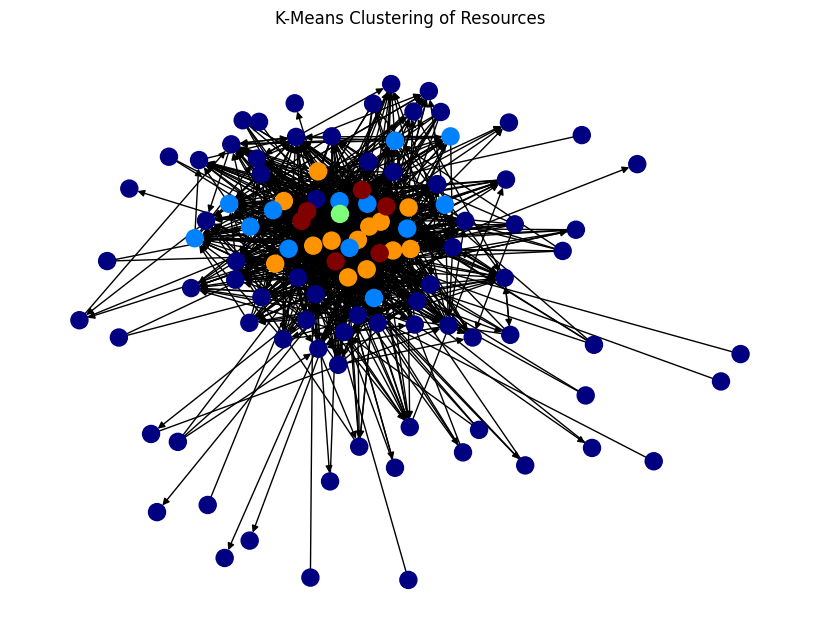

In [43]:
import matplotlib.pyplot as plt

# Get positions for the nodes in the graph
pos = nx.spring_layout(G)

# Get the cluster assignments for each node
node_colors = [resource_cluster[(node)] for node in G.nodes()]

# Draw the graph
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=False, node_color=node_colors, cmap=plt.cm.jet, node_size=150, font_size=0, font_color='white')
# edge_labels = nx.get_edge_attributes(G, 'weight')
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title('K-Means Clustering of Resources')
plt.show()

# Hierarchical clustering

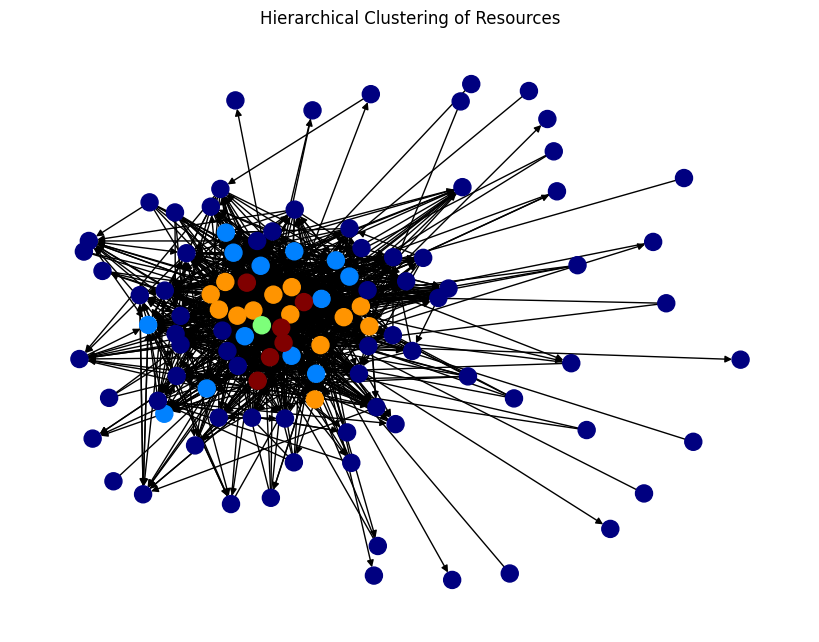

In [44]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Perform hierarchical clustering using the 'ward' linkage method
# Linkage computes the distance matrix between clusters
linked = linkage(handover_df.values, method='ward')

num_clusters = 5
cluster_labels = fcluster(linked, num_clusters, criterion='maxclust')

resource_cluster = dict(zip(values, kmeans.labels_))
import matplotlib.pyplot as plt

# Get positions for the nodes in the graph
pos = nx.spring_layout(G, seed=42)

# Get the cluster assignments for each node
node_colors = [resource_cluster[(node)] for node in G.nodes()]

# Draw the graph
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=False, node_color=node_colors, cmap=plt.cm.jet, node_size=150, font_size=0, font_color='white')
# edge_labels = nx.get_edge_attributes(G, 'weight')
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title('Hierarchical Clustering of Resources')
plt.show()